### 필요한 모듈 import

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import KFold, cross_val_score, train_test_split

import seaborn as sns

from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

### dataset 불러오기

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

## 1. 데이터 살펴보기
- 각 변수들이 나타내는 의미
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

### date를 int형의 연/월/일로 변환

In [3]:
train['date'] = train['date'].apply(lambda i: i[:8]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### price 데이터 전처리

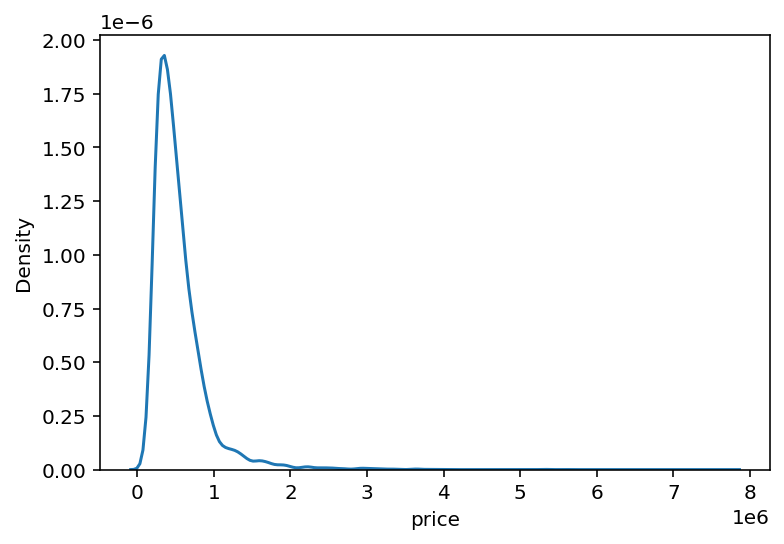

In [4]:
sns.kdeplot(train['price'])
plt.show()

### price 데이터가 정규분포를 따르지 않으므로 로그를 취해 정규화

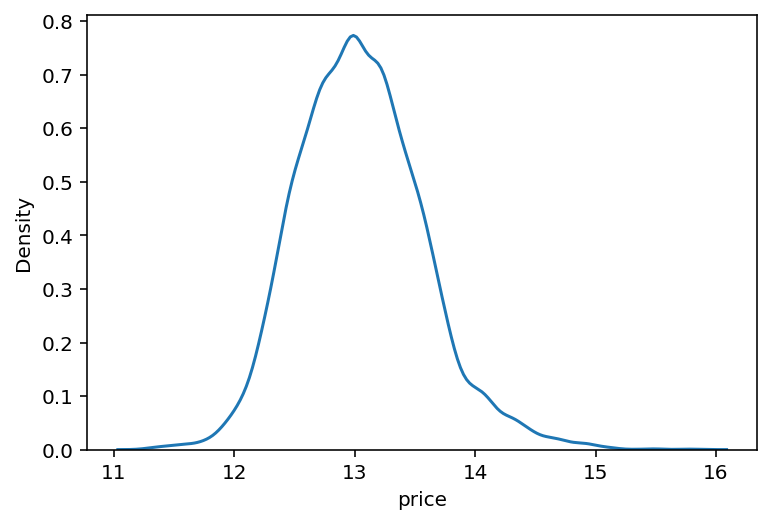

In [5]:
train['price'] = np.log1p(train['price'])

sns.kdeplot(train['price'])
plt.show()

### test 데이터셋도 같은 방식으로 전처리

In [6]:
test['date'] = test['date'].apply(lambda i: i[:8]).astype(int)
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


### 데이터 이상치 확인
https://www.kaggle.com/code/chocozzz/house-price-prediction-eda-updated-2019-03-12 에서 코드 및 설명 가져옴

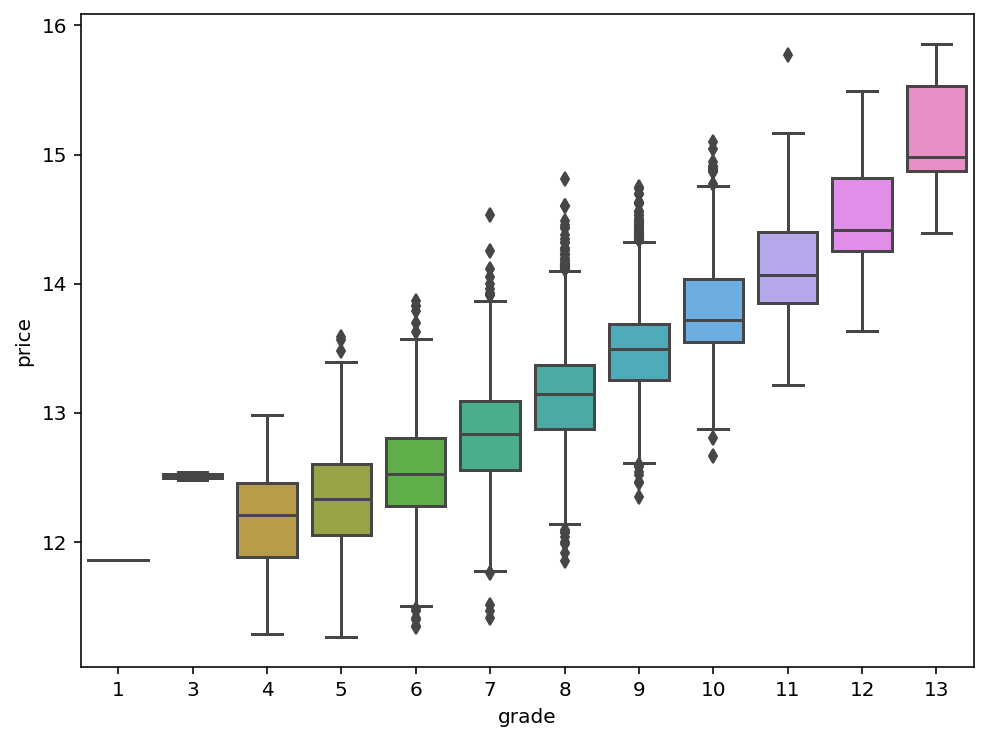

In [7]:
#grade와 price간 관계에서 이상치 확인
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

- grade3 에서 grade4 보다 높은 가격이 보임
- grade11에서 이상치 확인
- grade6~9에서 이상치가 많이 나오는 것을 확인할 수 있음

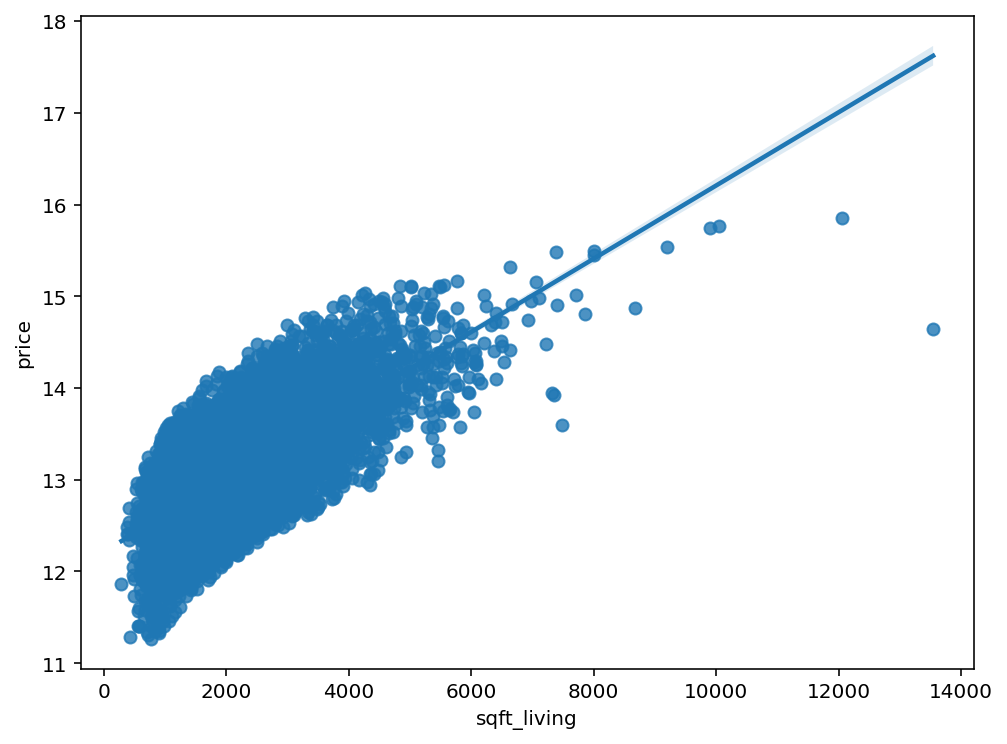

In [8]:
# price와 sqft_living 간의 관계에서 이상치 확인
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

- price 14~15 사이에 sqft_living이 14000 가까이 나옴
- sqlf_living / sqlf_lot (주거 평방 피트 / 부지 평방 피트) : 1sqlf는 0.0281평입니다. sqlf_lot는 부지 평방 피트인데, 흔히 우리나라의 경우, 32평형 아파트는 일반적으로 실제로 쓰는 전용 면적은 25.7평 정도입니다. 즉, sqlf_living은 실제 사용 면적 / sqlf_lot는 총 부지의 면적으로 생각하면 됩니다.

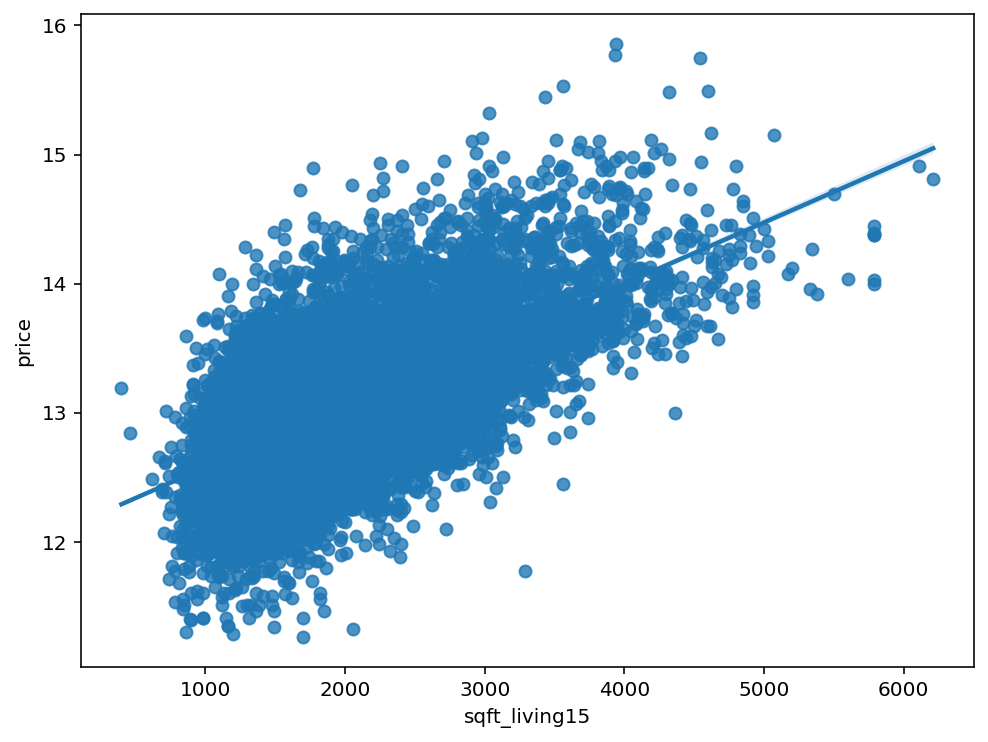

In [9]:
# price와 sqft_living15 간의 관계
data = pd.concat([train['price'], train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

재건축의 영향으로 sqft_living보다 분산이 큰 것으로 보임
- sqft_living15 그 자체를 사용하기보다는 적절한 FE이 필요해 보입니다.

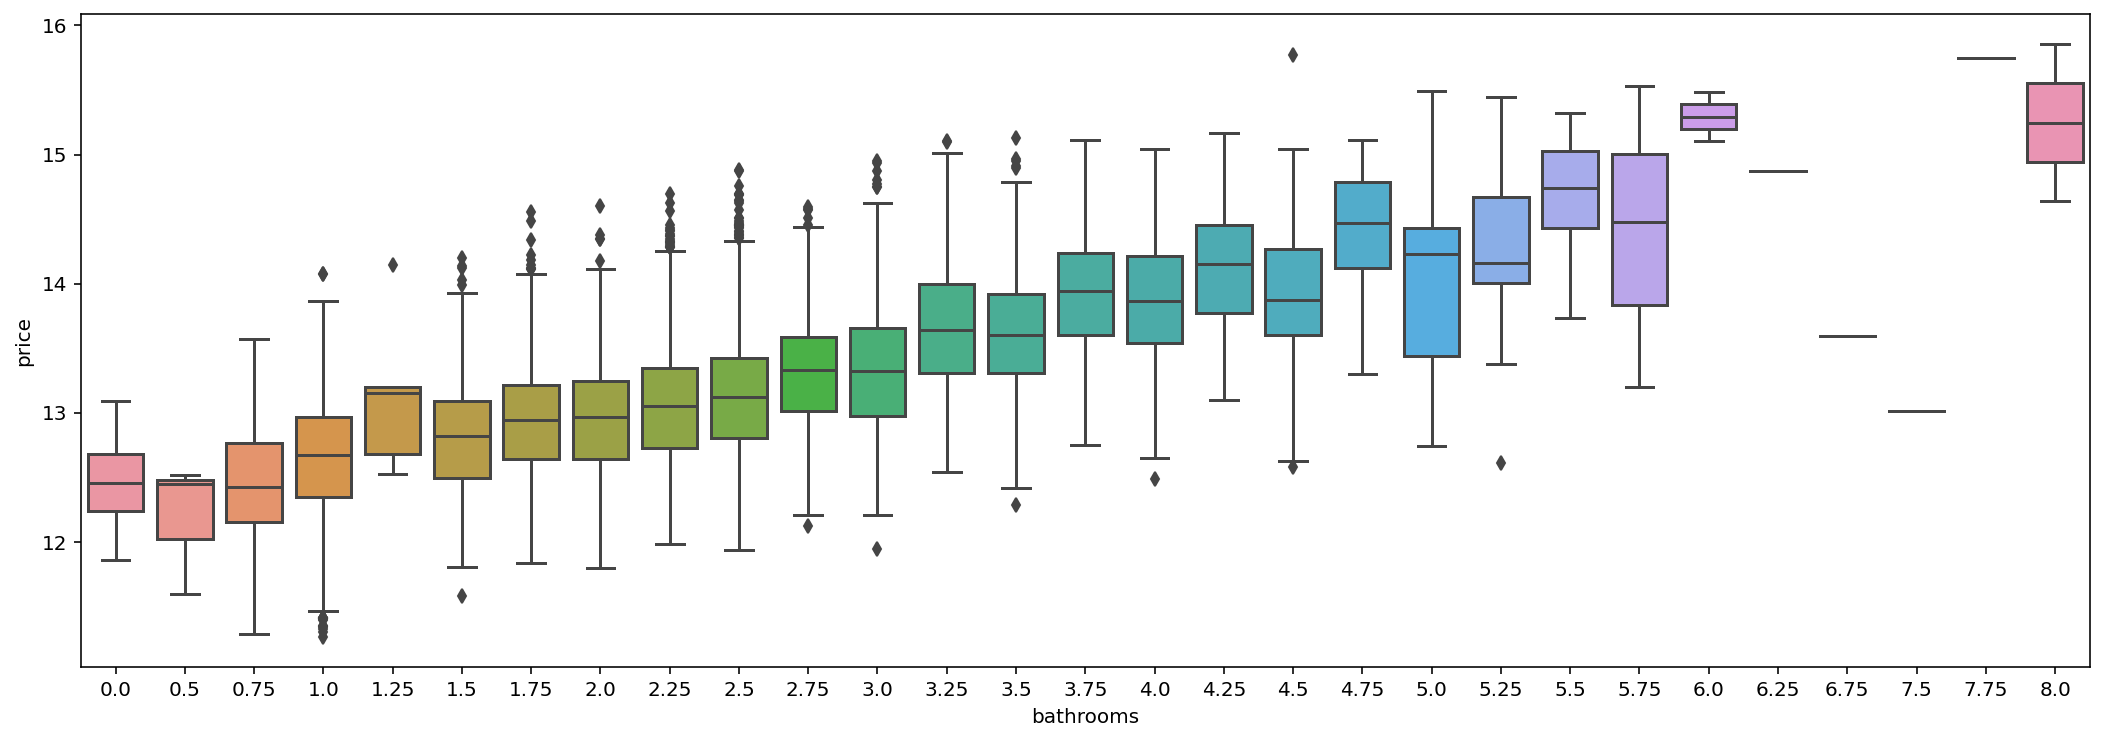

In [10]:
# price와 bathrooms 간의 관계
data = pd.concat([train['price'], train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

bathrooms같은경우 소숫점이 있어서 많이 헷갈릴 수 있습니다. 각각의 값이 의미하는것은 아래와 같고 위의 값만을 가지고 각각의 값이 몇개있는지는 구분하기 힘들어 보입니다.

- 0.5 : 세면대, 화장실
- 0.75 : 세면대, 화장실, 샤워실
- 1 : 세면대, 화장실, 샤워실, 욕조

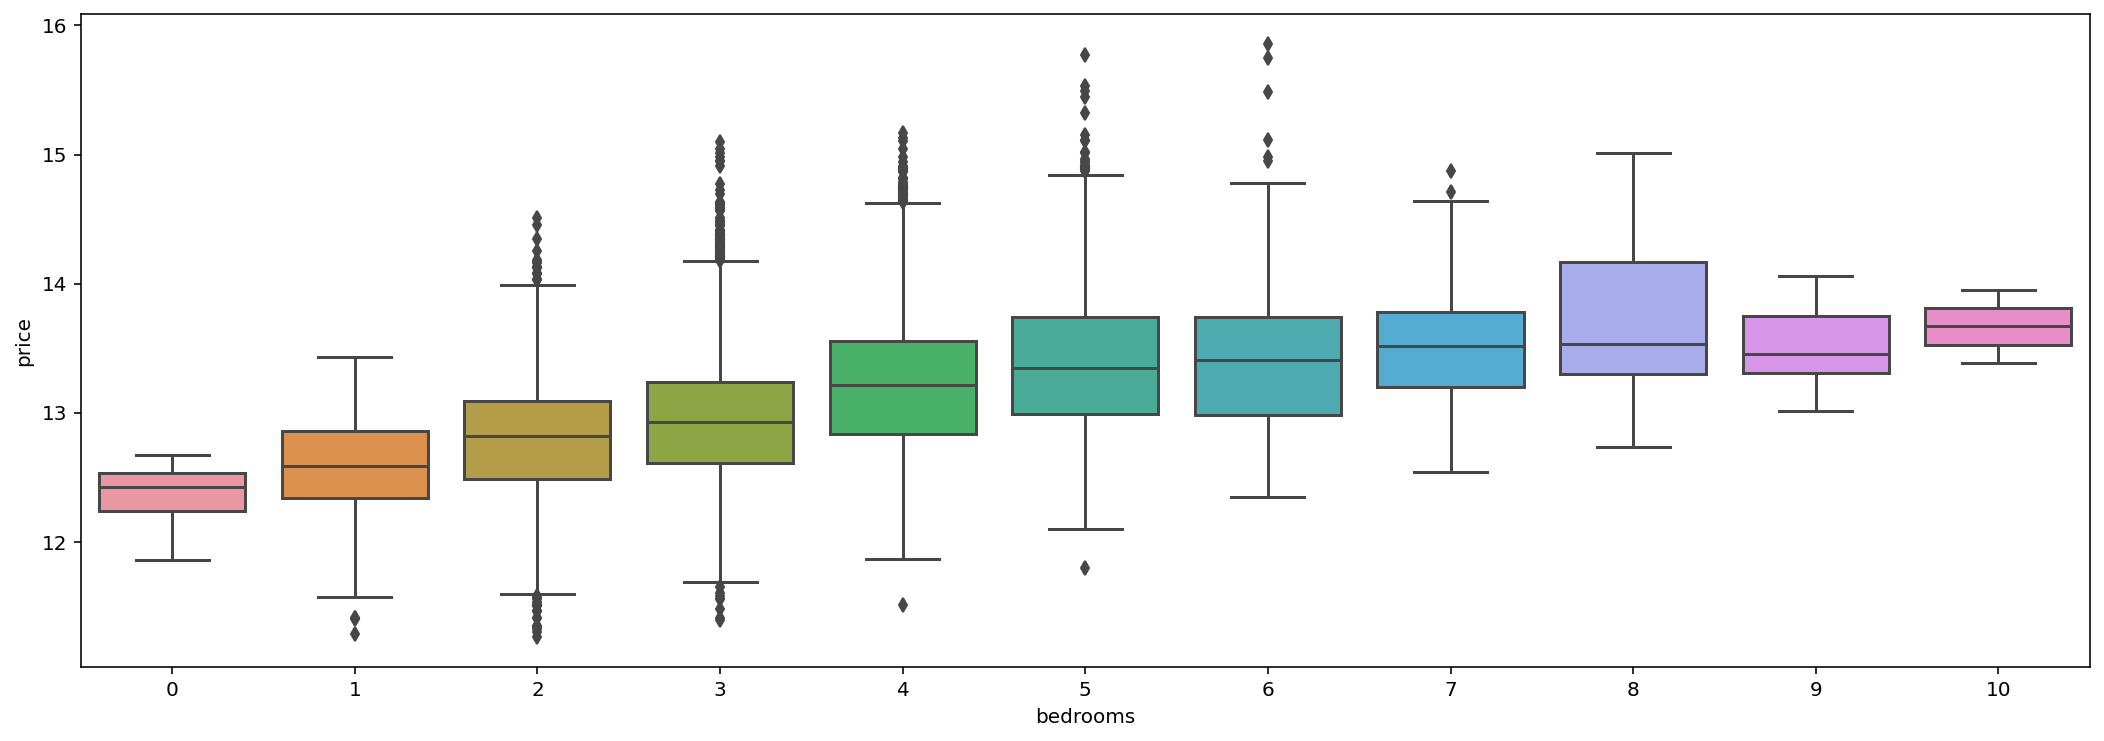

In [11]:
# price와 bedrooms 간의 관계
data = pd.concat([train['price'], train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

방의 경우 median 값을 중심으로 살펴보면 어느정도 선형관계를 띄는것을 볼 수 있습니다. 그리고 방의 갯수가 2~6의 경우 방이 적음에도 값이 큰 값들이 많습니다. 이는 우리나라의 경우처럼 방의 크기는 작아도 강남처럼 비싼 지역일 가능성이 높습니다.

### 결측치 확인

<AxesSubplot:>

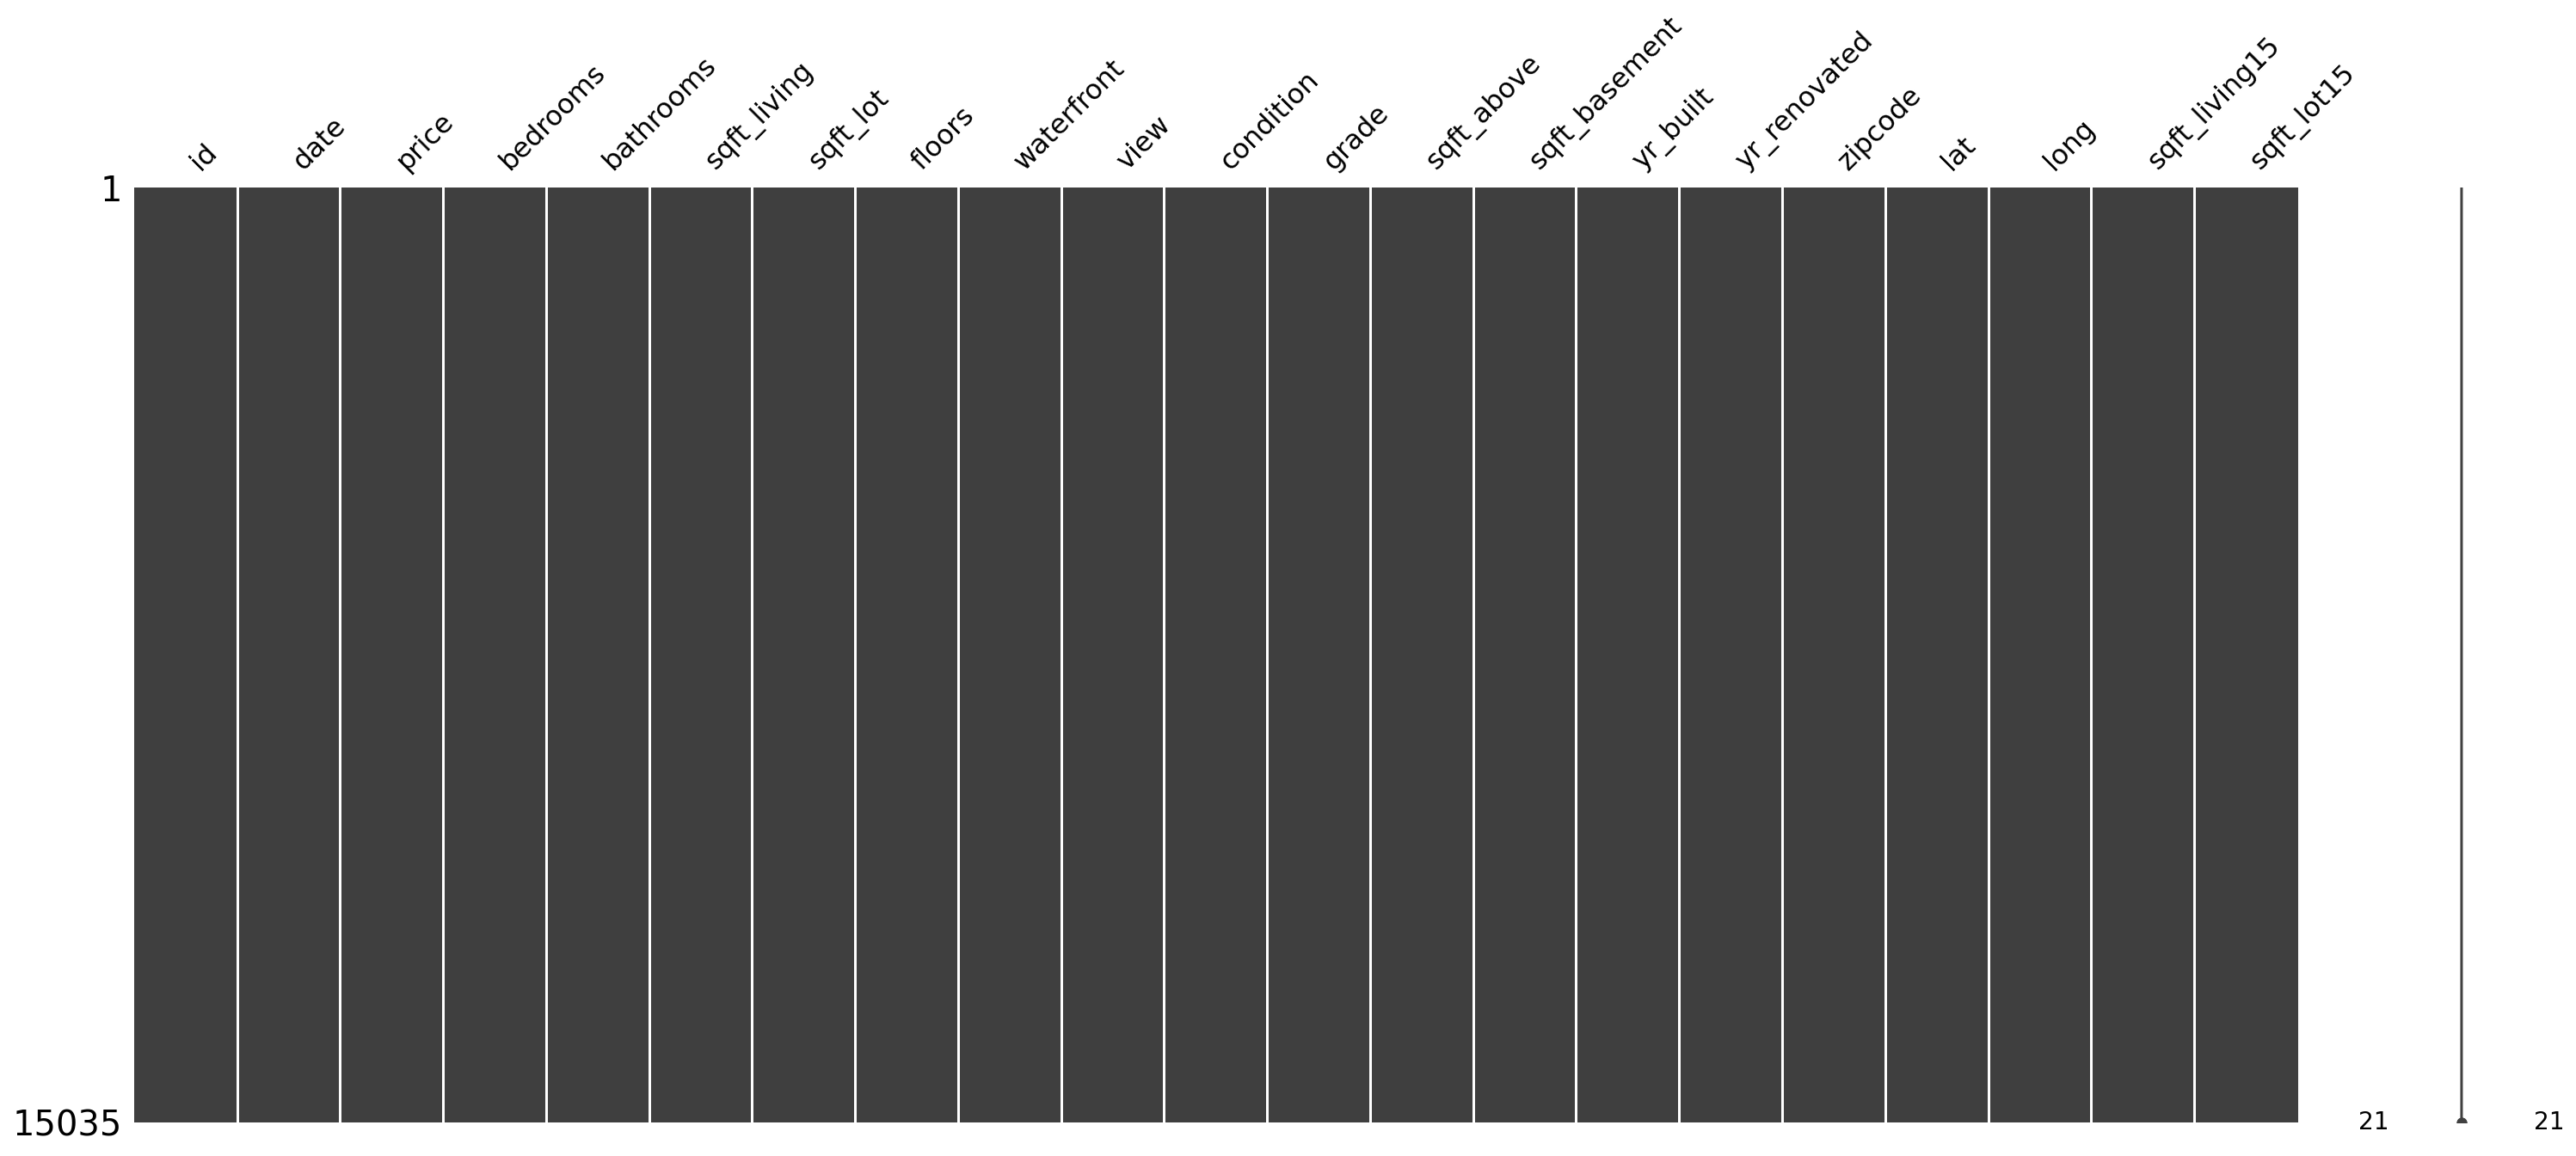

In [12]:
msno.matrix(train)

- 결측치가 없는 것으로 보임

In [13]:
# 결측치 개수 출력
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 이상치 제거
위에서 중요한 변수들에 대해 시각화를 해봤을때, 다음의 변수들에 대해 이상치가 있는 것을 확인할 수 있었습니다.
- sqft_living, grade, bedrooms

In [14]:
# sqft_living
train.loc[train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


위의 값을 봤을 때, 다른값들에 비해 sqft_living만 비정상적으로 꽤 큰 것을 알 수 있습니다. 추가적으로 price와 상관성이 높은 grade와 다른 평수들을 살펴봐도 큰 의미는 없어보이므로 제거하도록 하겠습니다.

In [15]:
train = train.drop(index=8912)
train.loc[train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [16]:
# grade
train.loc[(train['price']>12) & (train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


가장 중요한 변수인 grade, sqft_ 모두 낮은 것을 볼 수 있습니다. 그래서 두 값 모두 이상치로 규정하고 제거하도록 하겠습니다.

In [17]:
print(train.loc[(train['price']>14.7) & (train['grade'] == 8)])
train.loc[(train['price']>15.5) & (train['grade'] == 11)]

        id      date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
7173  7173  20140813  14.808763         5        4.0         4230     27295   

      floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
7173     2.0           1     4  ...      8        3230           1000   

      yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
7173      1949          1985    98033  47.6803 -122.214           2660   

      sqft_lot15  
7173       27295  

[1 rows x 21 columns]


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


위의 2값 모두 특별한 이유가 없이 가격이 높아 보이므로 이상치로 규정하고 제거하도록 하겠습니다.

In [18]:
train = train.drop(index=[2302, 4123, 7173, 2775])
train.loc[(train['price']>15.5) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


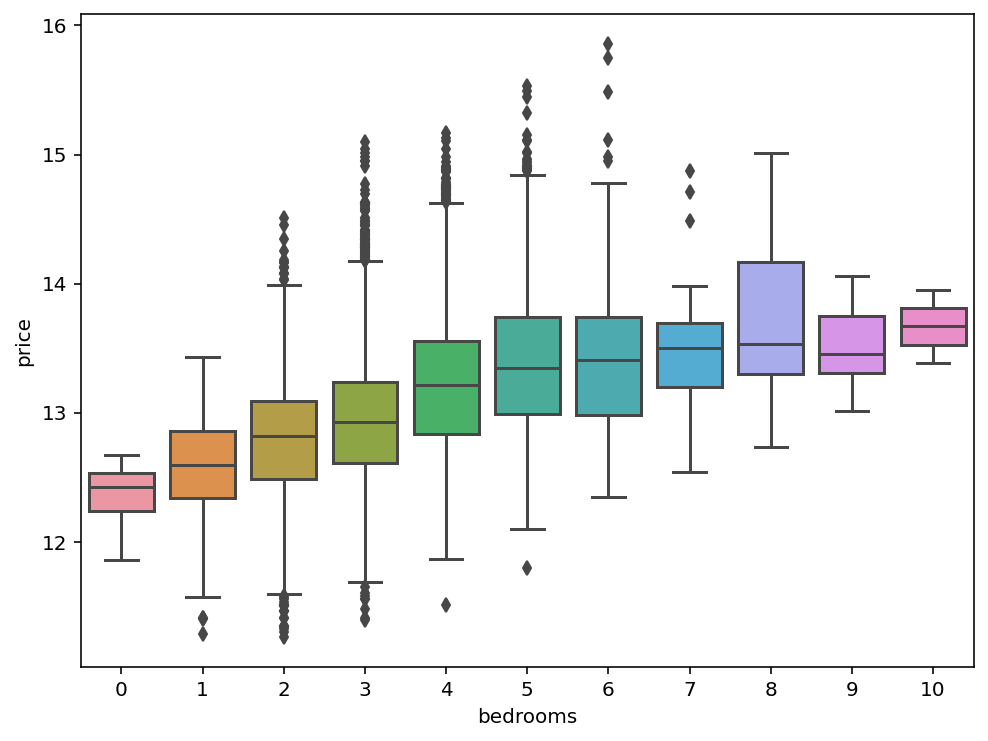

In [19]:
# bedrooms
data = pd.concat([train['price'], train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

- bedrooms에서 이상치가 보이지만 다른 변수들의 영향이 크기 때문에 이상치 제거는 하지 않겠습니다

### train, target data 분리

In [20]:
train_columns = [c for c in train.columns if c not in ['id','price']]
x = train[train_columns]
y = train['price']

In [21]:
x

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,20141014,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,20150326,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,20140521,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,20150223,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [22]:
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15030, dtype: float64

### RMSE 계산 함수 구현

In [23]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

### get_scores
각 모델 간의 점수 획득

In [24]:
def get_scores(models, train, y):
    df = {}
    for model in models:

        # train, test 데이터셋 분리 - random_state 고정 
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        
        # 모델 학습
        model['model'].fit(X_train, y_train)
        # 예측
        y_pred = model['model'].predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model['name']] = rmse(y_test, y_pred)
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

### my_GridSearch

In [25]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # params 정보 저장
    params = grid_model.cv_results_['params']
    # score 정보 저장
    score = grid_model.cv_results_['mean_test_score']
    
    # 결과 results에 DataFrame 형으로 저장
    results = pd.DataFrame(params)
    results['score'] = score
    # RMSLE 구하고 저장하기
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    # RMSLE가 높은 순서로 정렬
    results = results.sort_values('RMSLE')

    return results

### Averaging Blending

In [26]:
def AveragingBlending(models, x, y, test):
    for m in models : 
        m['model'].fit(x, y)
    
    predictions = np.column_stack([
        m['model'].predict(test) for m in models
    ])
    return np.mean(predictions, axis=1)

### param_grid

In [27]:
param_grid = {
    'n_estimators': [1000, 3000],
    'max_depth': [10, 20],
    'learning_rate': [0.01, 0.001]
}

### 각 모델의 점수 확인

In [28]:
random_state = 2022
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)

models = [{'model':gboost, 'name':'GradientBoosting'},
          {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]
scores = get_scores(models, train[train_columns], train['price'])

scores

,RMSE
GradientBoosting,164949.570697
LightGBM,139860.337456
XGBoost,136407.653927


### 각 모델의 Grid_Search

In [92]:
results={}
for model in models:
    results[model['name']] = my_GridSearch(model['model'], x, y, param_grid)
    print(model['name'])
    print(results[model['name']])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


KeyboardInterrupt: 

- 왜 이러는지는 모르겠지만... 3가지 모델 다 learning_rate, max_depth, n_estimators가 0.01, 10, 5000 일 때 점수가 가장 좋습니다.
    - my_GridSearch에 lgb만 학습시켜서 그런 것을 알아냈습니다
- csv로 파일을 저장한 후 점수가 11만점을 넘어 다시 하려고 했으나 grid search 진행 시간이 너무 느려 못했습니다.

### test 데이터 id column 삭제

In [29]:
test.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [30]:
del(test['id'])
test.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [31]:
model_lgb = LGBMRegressor(max_depth=20, n_estimators=3000, learning_rate=0.01, random_state=random_state)

model_gb = GradientBoostingRegressor(max_depth=20, n_estimators=3000, learning_rate=0.01, random_state=random_state)

model_xgb = XGBRegressor(max_depth=20, n_estimators=3000, learning_rate=0.01, random_state=random_state)

models = [{'model': model_lgb, 'name': 'lgbm'},
          {'model': model_gb, 'name': 'gb'},
          {'model': model_lgb, 'name': 'xgb'}]

predictions = AveragingBlending(models, x, y, test)
predictions

array([13.13393786, 13.13135975, 14.12225508, ..., 13.05246289,
       12.70719353, 13.06730294])

In [32]:
# log 스케일에서 원래 스케일로 변환
prediction = np.expm1(predictions)

In [39]:
model_lgb2 = LGBMRegressor(max_depth=10, n_estimators=5000, learning_rate=0.01, random_state=random_state)

model_gb2 = GradientBoostingRegressor(max_depth=10, n_estimators=5000, learning_rate=0.01, random_state=random_state)

model_xgb2 = XGBRegressor(max_depth=10, n_estimators=5000, learning_rate=0.01, random_state=random_state)

models2 = [{'model': model_lgb2, 'name': 'lgbm2'},
          {'model': model_gb2, 'name': 'gb2'},
          {'model': model_lgb2, 'name': 'xgb2'}]

prediction2 = AveragingBlending(models2, x, y, test)
prediction2

array([13.14006355, 13.08565247, 14.06135411, ..., 13.07131361,
       12.69573921, 12.98478221])

In [40]:
prediction2 = np.expm1(prediction2)

## csv 파일로 내보내기

In [33]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [34]:
# price 값 넣기
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.058199e+05
1,15036,5.045175e+05
2,15037,1.358993e+06
3,15038,2.867744e+05
4,15039,3.244183e+05


In [35]:
submission_csv_path = '{}/submission.csv'.format(data_dir)
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


In [36]:
submission['price'] = prediction2
submission.head()

NameError: name 'prediction2' is not defined

In [ ]:
submission_csv_path = '{}/submission2.csv'.format(data_dir)
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

# 회고
## 이번 프로젝트에서 어려웠던 점
- grid search를 진행하면서 많은 오류가 나와 고치느라 시간이 많이 걸렸다...

## 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
- 여러 학습 모델을 grid search 하는 함수를 만들었으나 너무 무거워서 중간에 함수가 종료되는 일이 있었다. 함수를 만들 때 한번에 너무 많은 작업을 하지 않도록 만들어야겠다.
- 1시간이면 grid search가 끝났었는데 (11만 3474점) 많은 시간이 걸려 점수를 더 낮추지는 못하였다.